In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

In [3]:
import pandas as pd
data=pd.read_csv('C:/Users/042300/Desktop/BAU/creditcard.csv')
data=data.drop(['Time'],axis=1)
y=data['Class']

In [4]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,y,test_size=0.2,random_state=123,stratify=y)
x_train_norm=x_train[x_train['Class']==0].drop(['Class'],axis=1)
x_train_fraud=x_train[x_train['Class']==1].drop(['Class'],axis=1)
x_test_norm=x_test[x_test['Class']==0].drop(['Class'],axis=1)
x_test_fraud=x_test[x_test['Class']==1].drop(['Class'],axis=1)
x_train=x_train.drop(['Class'],axis=1)
x_test=x_test.drop(['Class'],axis=1)

In [6]:
#AE
####Train-Dense-layer###
import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import TensorBoard
n_features =x_train_norm.shape[1]
epochs = 20
batch = 64
lr = 0.001
hidden_unit_1=10
hidden_unit_2=5
auto_encoder = Sequential()
# Encoder 
auto_encoder.add(Dense(hidden_unit_1, activation='relu', input_shape=(n_features,)))
auto_encoder.add(Dense(hidden_unit_2, activation='relu'))
# Decoder
auto_encoder.add(Dense(hidden_unit_2, activation='relu'))
auto_encoder.add(Dense(hidden_unit_1, activation='relu'))
auto_encoder.add(Dense(n_features, activation='linear'))
auto_encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                300       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_9 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_10 (Dense)             (None, 29)                319       
Total params: 764
Trainable params: 764
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
###optim
auto_encoder.compile(loss='mse', optimizer=optimizers.Adam(lr))
##earlystoping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc=ModelCheckpoint('best_auto.h5',monitor='val_loss',mode='auto',verbose=1,save_best_only=True)
###training
auto_encoder_history = auto_encoder.fit(x_train_norm.values, x_train_norm.values, epochs=epochs,validation_split=0.2,
                                        batch_size=batch,verbose=1,callbacks=[es,mc]).history

Train on 181960 samples, validate on 45491 samples
Epoch 1/20
181960/181960 [==============================] - 11s 59us/step - loss: 228.3573 - val_loss: 1.1962

Epoch 00001: val_loss improved from inf to 1.19623, saving model to best_auto.h5
Epoch 2/20
181960/181960 [==============================] - 11s 62us/step - loss: 1.5338 - val_loss: 1.0256

Epoch 00002: val_loss improved from 1.19623 to 1.02560, saving model to best_auto.h5
Epoch 3/20
181960/181960 [==============================] - 12s 67us/step - loss: 0.9197 - val_loss: 0.7349

Epoch 00003: val_loss improved from 1.02560 to 0.73491, saving model to best_auto.h5
Epoch 4/20
181960/181960 [==============================] - 12s 64us/step - loss: 1.4647 - val_loss: 1.0567

Epoch 00004: val_loss did not improve from 0.73491
Epoch 5/20
181960/181960 [==============================] - 11s 60us/step - loss: 1.2111 - val_loss: 0.7198

Epoch 00005: val_loss improved from 0.73491 to 0.71984, saving model to best_auto.h5
Epoch 6/20
1819

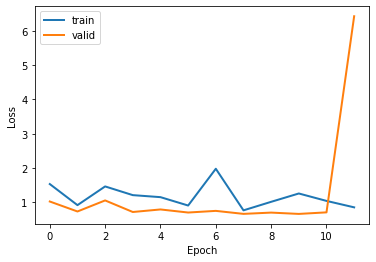

In [8]:
%matplotlib inline
plt.plot(auto_encoder_history['loss'][1:-1], linewidth=2, label='train')
plt.plot(auto_encoder_history['val_loss'][1:-1], linewidth=2, label='valid')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
best_AE=tf.keras.models.load_model('best_auto.h5')

In [10]:
predict_normal=best_AE.predict(x_test_norm.values)
mse_normal=np.mean(np.power( predict_normal - x_test_norm.values, 2),axis=1)

In [11]:
predict_fraud=best_AE.predict(x_test_fraud.values)
mse_fraud=np.mean(np.power( predict_fraud - x_test_fraud.values, 2),axis=1)

In [12]:
mse_normal.mean()

0.6530551174676869

In [13]:
mse_fraud.mean()

17.930624149895035

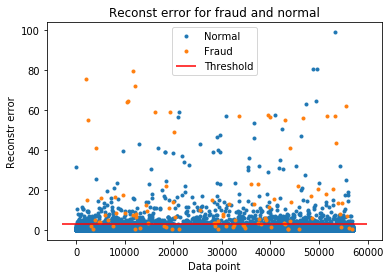

In [14]:
threshold_fixed = 3
import pandas as pd
from sklearn.utils import shuffle
## Compare the reconstruct-error
error_df=pd.DataFrame({'Recons_error':mse_normal,'isFraud':0})
error_df=pd.concat([error_df,pd.DataFrame({'Recons_error':mse_fraud,'isFraud':1})],axis=0)
error_df = shuffle(error_df)
error_df=pd.DataFrame({'Recons_error':error_df['Recons_error'].values,'isFraud':error_df['isFraud'].values})
groups = error_df.groupby('isFraud')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Recons_error, marker='o', ms=3.0, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconst error for fraud and normal")
plt.ylabel("Reconstr error")
plt.xlabel("Data point")
plt.show()


In [15]:
sum(mse_fraud>3)/len(mse_fraud)

0.7551020408163265

In [16]:
sum(mse_normal>3)/len(mse_normal)

0.013875211029825548

In [17]:
y_test_predict=best_AE.predict(x_test.values)
mse_test=np.mean(np.power( y_test_predict - x_test.values, 2),axis=1)

In [18]:
y_test_predict=[1 if i >10 else 0 for i in mse_test]
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
print(confusion_matrix(y_test.values,y_test_predict))
metrics=pd.Series([precision_score,
recall_score,
f1_score])
metrics.apply(lambda x:x(y_test.values,y_test_predict))

[[56716   148]
 [   54    44]]


0    0.229167
1    0.448980
2    0.303448
dtype: float64

In [ ]:
##T-SNE
def tsne_plot(X, y, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(X)
    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], 
                X_t[np.where(y1 == 0), 1], 
                marker='o', color='g', 
                linewidth='1', 
                alpha=0.8, 
                label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], 
                X_t[np.where(y1 == 1), 1], 
                marker='o', color='r', 
                linewidth='1', 
                alpha=0.8, 
                label='Fraud')
    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(x_train,y_train)

In [32]:
hidden_representation = Sequential()
hidden_representation.add(auto_encoder.layers[0])
hidden_representation.add(auto_encoder.layers[1])
hidden_representation.add(auto_encoder.layers[2])

In [33]:
hidden_representation.predict(x_train_norm[:200])

array([[1.21420679e+01, 2.05239224e+00, 4.43142014e+01, 8.31779099e+00,
        1.96414280e+00],
       [0.00000000e+00, 1.88493657e+00, 6.17661667e+00, 2.28941369e+00,
        9.58861530e-01],
       [5.72886705e-01, 4.08548403e+00, 1.89629555e+00, 2.96394378e-02,
        3.83366632e+00],
       [4.60795689e+00, 3.25723529e+00, 7.26656866e+00, 1.60945189e+00,
        9.01821673e-01],
       [4.17434597e+00, 4.59242868e+00, 2.91562247e+00, 9.73485112e-01,
        1.46654081e+00],
       [1.28245840e+01, 8.71282279e-01, 5.19788666e+01, 9.72405624e+00,
        2.38670993e+00],
       [3.31927729e+00, 2.45866919e+00, 1.18223181e+01, 1.69374681e+00,
        2.74608135e+00],
       [4.55744133e+01, 2.42188954e+00, 2.12958420e+02, 4.04577560e+01,
        7.05785227e+00],
       [1.86874986e+00, 2.29817734e+01, 2.77393436e+00, 1.14113951e+01,
        0.00000000e+00],
       [1.81807251e+01, 4.35929823e+00, 5.36596260e+01, 1.21040735e+01,
        1.49049306e+00],
       [0.00000000e+00, 3.5137

In [ ]:
cnxn = pyodbc.connect('Driver={SQL Server};'
                              'Server=10.13.11.4;'
                              'Database=WRCT;'
                              'Trusted_Connection=yes;')
df = pd.read_sql(sql2,cnxn,index_col=None)